In [1]:
from __future__ import (division, print_function, absolute_import)

In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function

In [3]:
# Pixel 42 : [ 0.612372, 0.612372, 0.500000 ]
# Pixel 57 : [ 0.783917, 0.523797, 0.333333 ]
# Pixel 58 : [ 0.523797, 0.783917, 0.333333 ]
# Pixel 74 : [ 0.697217, 0.697217, 0.166667 ]

In [4]:
#
# We define this pixel patch
#
# Note: We have to put into IDL format for 3D vectors, i.e. 
# HDIL> query_polygon, 512L, [[0.612372, 0.783917, 0.523797, 0.697217], 
#       [0.612372, 0.523797, 0.783917, 0.697217], [0.500000, 0.333333, 0.333333, 0.166667]], listpix3, nlist3
#

In [5]:
#
# Now, save IDL .sav file of listpix3
# Import into Python and run
#

In [6]:
# http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.io.readsav.html
# http://www.astrobetter.com/blog/2009/11/24/read-idl-save-files-into-python/

In [7]:
import scipy

In [8]:
#
# scipy.io.readsav
#
# scipy.io.readsav(file_name, idict=None, python_dict=False, uncompressed_file_name=None, verbose=False)[source]
#
# Read an IDL .sav file
#
#

In [9]:
cd ~/Downloads

/Users/evanbiederstedt/Downloads


In [10]:
import scipy.io

In [11]:
patch_file = scipy.io.readsav('patch_listpix3.sav')

In [12]:
type(patch_file)

scipy.io.idl.AttrDict

In [13]:
arr3 = patch_file['listpix3']
print(arr3)

[ 787712  789759  789760 ..., 1303809 1305856 1307904]


In [14]:
type(arr3)

numpy.ndarray

In [15]:
print(len(arr3)) # pixels total 12476

12476


In [16]:
camb_map512 = "camb_map_nside512.fits"

In [17]:
camb_map512

'camb_map_nside512.fits'

In [18]:
nside=512
npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print("The total number of pixels is " + str(npix))
print("The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX))
print("Healpix tells me total number of pixels npix is equal to " + str(heal_npix))

The total number of pixels is 3145728
The maximum ell of the power spectrum C_l set to lmax = 2*nside 1024
Healpix tells me total number of pixels npix is equal to 3145728


NSIDE = 512
ORDERING = RING in fits file


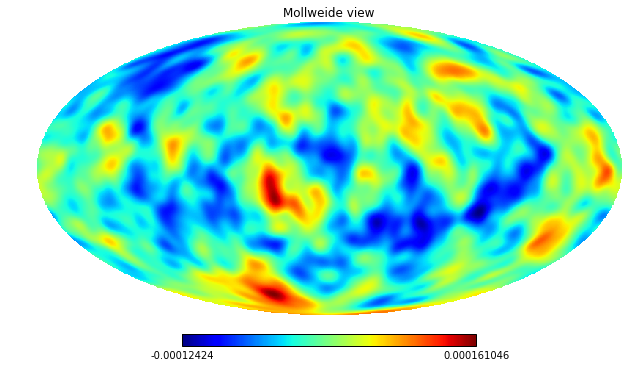

In [19]:
mapread_camb512 = hp.read_map(camb_map512)
#hp.mollview(mapread_camb512)

In [20]:
# rename array for convenience
tempval = mapread_camb512
#print tempval

# Data:
#     tempval      # the array of pixel values, (3145728,)

In [21]:
print(len(tempval))
print(tempval.shape)

3145728
(3145728,)


In [22]:
#
# We only wish to use the pixels defined in our patch
# These pixel indices are listed in arr3 such that total number pixels total 12476
#
# arr3: this defines pixel indices within patch
# 
# To access pixel indices within array of CMB pixels, just use tempval[arr3]
#

In [23]:
print(len(tempval[arr3]))

12476


In [24]:
# The log-likelihood
#
# -2lnL \propto m^T C^-1 m + ln det C + N ln (2pi)
#
# First term, m^T C^-1 m is the "model fit term"
# Second term, lndetC is the "complexity penalty"
# Third term, N ln 2pi, a constant
#
# m = tempval
# C = Sij

In [25]:
m = tempval[arr3]

In [26]:
# Next, create the matrix, n_i /cdot n_j
# solely using Healpy routines, i.e. taking the dot product of the vectors
# The result is "dotproductmatrix"

In [27]:
npix

3145728

In [28]:
nside

512

In [29]:
## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple

In [30]:
vecval = hp.pix2vec(nside, arr3) #Nside = 512, type()=tuple

In [31]:
len(vecval)

3

In [32]:
vecvalx = vecval[0] #len() = 12476
vecvaly = vecval[1]
vecvalz = vecval[2]

In [33]:
# First arrange arrays vertically
# numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays
totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray

In [34]:
trans = totalvecval.T #transpose


In [35]:
dotproductmatrix = trans.dot(totalvecval) #take the dot product
# dotproductmatrix.shape = (npix, npix) = (12476, 12476)
# type(dotproductmatrix) = np.ndarray

In [36]:
#
# The following procedure is for the angular power spectrum, C^th_ell
# However, we are using some cosmological parameter, /alpha
#
#
# =========================================================
# =========================================================
#
# \Sum_l (2*l + 1)/4pi C^th_l P_l (dotproductmatrix)
# sum from l=2 to l=lmax
#
# arrays l = [2 3 4 .... lmax]
#        C_l = [C_2 C_3 .... C_lmax]
#
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         
#
#
# =========================================================
# =========================================================

In [37]:
print(dotproductmatrix)

[[ 1.          0.99999799  0.99999799 ...,  0.93913365  0.93868192
   0.93822665]
 [ 0.99999799  1.          0.99999646 ...,  0.9396434   0.93919556
   0.93874416]
 [ 0.99999799  0.99999646  1.         ...,  0.93965145  0.93919958
   0.93874416]
 ..., 
 [ 0.93913365  0.9396434   0.93965145 ...,  1.          0.99999798
   0.99999194]
 [ 0.93868192  0.93919556  0.93919958 ...,  0.99999798  1.          0.99999798]
 [ 0.93822665  0.93874416  0.93874416 ...,  0.99999194  0.99999798  1.        ]]


In [38]:
#
# Let's first just take l_max = nside
# so, that's lmax = 512
#

In [39]:
# For lmax = 512, we must create an array of ell values, i.e. [0 1 2 3....31 32]
ell = np.arange(513)
print(ell)
# 
# Subtract the monopole and dipole, l=0, l=1
ellval = ell[2:]
print(ellval)


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [40]:
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         

In [41]:
dotproductmatrix.shape

(12476, 12476)

In [42]:
# Step 1: calculate the matrix
M = dotproductmatrix

In [43]:
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]


In [44]:
# CODE BOTTLENECK!
# 
# Evaluate Legendre from l=2 to l=lmax for each matrix entry
# [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# 
# WITHOUT BROADCASTING, one would do something like 
# PlMat = []
# for i in ellval:
#    PlMat.append( eval_legendre(i, dotproductmatrix) )
#
#
# With broadcasting, we use
# PlMat = eval_legendre(ellval[:, None, None], dotproductmatrix)
# PlMat = [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# PlMat is an array, len()=31 of 31 3072 by 3072 matrices
# PlMat.shape = (31, 3072, 3072)

In [45]:
#This doesn't run for lmax=512
#So, split 'ellval' into ten arrays and then sum afterwards

splitell = np.array_split(ellval, 150)
splitell[0]

array([2, 3, 4, 5])

In [46]:
PlMat1 = eval_legendre(splitell[0][:, None, None], dotproductmatrix)

In [47]:
PlMat2 = eval_legendre(splitell[1][:, None, None], dotproductmatrix)

In [48]:
PlMat3 = eval_legendre(splitell[2][:, None, None], dotproductmatrix)

In [49]:
PlMat4 = eval_legendre(splitell[3][:, None, None], dotproductmatrix)

In [50]:
PlMat5 = eval_legendre(splitell[4][:, None, None], dotproductmatrix)

In [51]:
PlMat6 = eval_legendre(splitell[5][:, None, None], dotproductmatrix)

KeyboardInterrupt: 

In [ ]:
PlMat7 = eval_legendre(splitell[6][:, None, None], dotproductmatrix)

In [ ]:
PlMat8 = eval_legendre(splitell[7][:, None, None], dotproductmatrix)

In [ ]:
PlMat9 = eval_legendre(splitell[8][:, None, None], dotproductmatrix)

In [ ]:
PlMat10 = eval_legendre(splitell[9][:, None, None], dotproductmatrix)

In [ ]:
PlMat11 = eval_legendre(splitell[10][:, None, None], dotproductmatrix)

In [ ]:
PlMat12 = eval_legendre(splitell[11][:, None, None], dotproductmatrix)

In [ ]:
PlMat13 = eval_legendre(splitell[12][:, None, None], dotproductmatrix)

In [ ]:
PlMat14 = eval_legendre(splitell[13][:, None, None], dotproductmatrix)

In [ ]:
PlMat15 = eval_legendre(splitell[14][:, None, None], dotproductmatrix)

In [ ]:
PlMat16 = eval_legendre(splitell[15][:, None, None], dotproductmatrix)

In [ ]:
PlMat17 = eval_legendre(splitell[16][:, None, None], dotproductmatrix)

In [ ]:
PlMat18 = eval_legendre(splitell[17][:, None, None], dotproductmatrix)

In [ ]:
PlMat19 = eval_legendre(splitell[18][:, None, None], dotproductmatrix)

In [ ]:
PlMat20 = eval_legendre(splitell[19][:, None, None], dotproductmatrix)

In [ ]:
PlMat21 = eval_legendre(splitell[20][:, None, None], dotproductmatrix)

In [ ]:
PlMat22 = eval_legendre(splitell[21][:, None, None], dotproductmatrix)

In [ ]:
PlMat23 = eval_legendre(splitell[22][:, None, None], dotproductmatrix)

In [ ]:
PlMat24 = eval_legendre(splitell[23][:, None, None], dotproductmatrix)

In [ ]:
PlMat25 = eval_legendre(splitell[24][:, None, None], dotproductmatrix)

In [ ]:
PlMat26 = eval_legendre(splitell[25][:, None, None], dotproductmatrix)

In [ ]:
PlMat27 = eval_legendre(splitell[26][:, None, None], dotproductmatrix)

In [ ]:
PlMat28 = eval_legendre(splitell[27][:, None, None], dotproductmatrix)

In [ ]:
PlMat29 = eval_legendre(splitell[28][:, None, None], dotproductmatrix)

In [ ]:
PlMat30 = eval_legendre(splitell[29][:, None, None], dotproductmatrix)

In [ ]:
PlMat31 = eval_legendre(splitell[30][:, None, None], dotproductmatrix)

In [ ]:
PlMat32 = eval_legendre(splitell[31][:, None, None], dotproductmatrix)

In [ ]:
PlMat33 = eval_legendre(splitell[32][:, None, None], dotproductmatrix)

In [ ]:
PlMat34 = eval_legendre(splitell[33][:, None, None], dotproductmatrix)

In [ ]:
PlMat35 = eval_legendre(splitell[34][:, None, None], dotproductmatrix)

In [ ]:
PlMat36 = eval_legendre(splitell[35][:, None, None], dotproductmatrix)

In [ ]:
PlMat37 = eval_legendre(splitell[36][:, None, None], dotproductmatrix)

In [ ]:
PlMat38 = eval_legendre(splitell[37][:, None, None], dotproductmatrix)

In [ ]:
PlMat39 = eval_legendre(splitell[38][:, None, None], dotproductmatrix)

In [ ]:
PlMat40 = eval_legendre(splitell[39][:, None, None], dotproductmatrix)

In [ ]:
PlMat41 = eval_legendre(splitell[40][:, None, None], dotproductmatrix)

In [ ]:
PlMat42 = eval_legendre(splitell[41][:, None, None], dotproductmatrix)

In [ ]:
PlMat43 = eval_legendre(splitell[42][:, None, None], dotproductmatrix)

In [ ]:
PlMat44 = eval_legendre(splitell[43][:, None, None], dotproductmatrix)

In [ ]:
PlMat45 = eval_legendre(splitell[44][:, None, None], dotproductmatrix)

In [ ]:
PlMat46 = eval_legendre(splitell[45][:, None, None], dotproductmatrix)

In [ ]:
PlMat47 = eval_legendre(splitell[46][:, None, None], dotproductmatrix)

In [ ]:
PlMat48 = eval_legendre(splitell[47][:, None, None], dotproductmatrix)

In [ ]:
PlMat49 = eval_legendre(splitell[48][:, None, None], dotproductmatrix)

In [ ]:
PlMat50 = eval_legendre(splitell[49][:, None, None], dotproductmatrix)

In [ ]:
PlMat51 = eval_legendre(splitell[50][:, None, None], dotproductmatrix)

In [ ]:
PlMat52 = eval_legendre(splitell[51][:, None, None], dotproductmatrix)

In [ ]:
PlMat53 = eval_legendre(splitell[52][:, None, None], dotproductmatrix)

In [ ]:
PlMat54 = eval_legendre(splitell[53][:, None, None], dotproductmatrix)

In [ ]:
PlMat55 = eval_legendre(splitell[54][:, None, None], dotproductmatrix)

In [ ]:
PlMat56 = eval_legendre(splitell[55][:, None, None], dotproductmatrix)

In [ ]:
PlMat57 = eval_legendre(splitell[56][:, None, None], dotproductmatrix)

In [ ]:
PlMat58 = eval_legendre(splitell[57][:, None, None], dotproductmatrix)

In [ ]:
PlMat59 = eval_legendre(splitell[58][:, None, None], dotproductmatrix)

In [ ]:
PlMat60 = eval_legendre(splitell[59][:, None, None], dotproductmatrix)

In [ ]:
PlMat61 = eval_legendre(splitell[60][:, None, None], dotproductmatrix)

In [ ]:
PlMat62 = eval_legendre(splitell[61][:, None, None], dotproductmatrix)

In [ ]:
PlMat63 = eval_legendre(splitell[62][:, None, None], dotproductmatrix)

In [ ]:
PlMat64 = eval_legendre(splitell[63][:, None, None], dotproductmatrix)

In [ ]:
PlMat65 = eval_legendre(splitell[64][:, None, None], dotproductmatrix)

In [ ]:
PlMat66 = eval_legendre(splitell[65][:, None, None], dotproductmatrix)

In [ ]:
PlMat67 = eval_legendre(splitell[66][:, None, None], dotproductmatrix)

In [ ]:
PlMat68 = eval_legendre(splitell[67][:, None, None], dotproductmatrix)

In [ ]:
PlMat69 = eval_legendre(splitell[68][:, None, None], dotproductmatrix)

In [ ]:
PlMat70 = eval_legendre(splitell[69][:, None, None], dotproductmatrix)

In [ ]:
PlMat71 = eval_legendre(splitell[70][:, None, None], dotproductmatrix)

In [ ]:
PlMat72 = eval_legendre(splitell[71][:, None, None], dotproductmatrix)

In [ ]:
PlMat73 = eval_legendre(splitell[72][:, None, None], dotproductmatrix)

In [ ]:
PlMat74 = eval_legendre(splitell[73][:, None, None], dotproductmatrix)

In [ ]:
PlMat75 = eval_legendre(splitell[74][:, None, None], dotproductmatrix)

In [ ]:
PlMat76 = eval_legendre(splitell[75][:, None, None], dotproductmatrix)

In [ ]:
PlMat77 = eval_legendre(splitell[76][:, None, None], dotproductmatrix)

In [ ]:
PlMat78 = eval_legendre(splitell[77][:, None, None], dotproductmatrix)

In [ ]:
PlMat79 = eval_legendre(splitell[78][:, None, None], dotproductmatrix)

In [ ]:
PlMat80 = eval_legendre(splitell[79][:, None, None], dotproductmatrix)

In [ ]:
PlMat81 = eval_legendre(splitell[80][:, None, None], dotproductmatrix)

In [ ]:
PlMat82 = eval_legendre(splitell[81][:, None, None], dotproductmatrix)

In [ ]:
PlMat83 = eval_legendre(splitell[82][:, None, None], dotproductmatrix)

In [ ]:
PlMat84 = eval_legendre(splitell[83][:, None, None], dotproductmatrix)

In [ ]:
PlMat85 = eval_legendre(splitell[84][:, None, None], dotproductmatrix)

In [ ]:
PlMat86 = eval_legendre(splitell[85][:, None, None], dotproductmatrix)

In [ ]:
PlMat87 = eval_legendre(splitell[86][:, None, None], dotproductmatrix)

In [ ]:
PlMat88 = eval_legendre(splitell[87][:, None, None], dotproductmatrix)

In [ ]:
PlMat89 = eval_legendre(splitell[88][:, None, None], dotproductmatrix)

In [ ]:
PlMat90 = eval_legendre(splitell[89][:, None, None], dotproductmatrix)

In [ ]:
PlMat91 = eval_legendre(splitell[90][:, None, None], dotproductmatrix)

In [ ]:
PlMat92 = eval_legendre(splitell[91][:, None, None], dotproductmatrix)

In [ ]:
PlMat93 = eval_legendre(splitell[92][:, None, None], dotproductmatrix)

In [ ]:
PlMat94 = eval_legendre(splitell[93][:, None, None], dotproductmatrix)

In [ ]:
PlMat95 = eval_legendre(splitell[94][:, None, None], dotproductmatrix)

In [ ]:
PlMat96 = eval_legendre(splitell[95][:, None, None], dotproductmatrix)

In [ ]:
PlMat97 = eval_legendre(splitell[96][:, None, None], dotproductmatrix)

In [ ]:
PlMat98 = eval_legendre(splitell[97][:, None, None], dotproductmatrix)

In [ ]:
PlMat99 = eval_legendre(splitell[98][:, None, None], dotproductmatrix)

In [ ]:
PlMat100 = eval_legendre(splitell[99][:, None, None], dotproductmatrix)

In [ ]:
PlMat101 = eval_legendre(splitell[100][:, None, None], dotproductmatrix)

In [ ]:
PlMat102 = eval_legendre(splitell[101][:, None, None], dotproductmatrix)

In [ ]:
PlMat103 = eval_legendre(splitell[102][:, None, None], dotproductmatrix)

In [ ]:
PlMat104 = eval_legendre(splitell[103][:, None, None], dotproductmatrix)

In [ ]:
PlMat105 = eval_legendre(splitell[104][:, None, None], dotproductmatrix)

In [ ]:
PlMat106 = eval_legendre(splitell[105][:, None, None], dotproductmatrix)

In [ ]:
PlMat107 = eval_legendre(splitell[106][:, None, None], dotproductmatrix)

In [ ]:
PlMat108 = eval_legendre(splitell[107][:, None, None], dotproductmatrix)

In [ ]:
PlMat109 = eval_legendre(splitell[108][:, None, None], dotproductmatrix)

In [ ]:
PlMat110 = eval_legendre(splitell[109][:, None, None], dotproductmatrix)

In [ ]:
PlMat111 = eval_legendre(splitell[110][:, None, None], dotproductmatrix)

In [ ]:
PlMat112 = eval_legendre(splitell[111][:, None, None], dotproductmatrix)

In [ ]:
PlMat113 = eval_legendre(splitell[112][:, None, None], dotproductmatrix)

In [ ]:
PlMat114 = eval_legendre(splitell[113][:, None, None], dotproductmatrix)

In [ ]:
PlMat115 = eval_legendre(splitell[114][:, None, None], dotproductmatrix)

In [ ]:
PlMat116 = eval_legendre(splitell[115][:, None, None], dotproductmatrix)

In [ ]:
PlMat117 = eval_legendre(splitell[116][:, None, None], dotproductmatrix)

In [ ]:
PlMat118 = eval_legendre(splitell[117][:, None, None], dotproductmatrix)

In [ ]:
PlMat119 = eval_legendre(splitell[118][:, None, None], dotproductmatrix)

In [ ]:
PlMat120 = eval_legendre(splitell[119][:, None, None], dotproductmatrix)

In [ ]:
PlMat121 = eval_legendre(splitell[120][:, None, None], dotproductmatrix)

In [ ]:
PlMat122 = eval_legendre(splitell[121][:, None, None], dotproductmatrix)

In [ ]:
PlMat123 = eval_legendre(splitell[122][:, None, None], dotproductmatrix)

In [ ]:
PlMat124 = eval_legendre(splitell[123][:, None, None], dotproductmatrix)

In [ ]:
PlMat125 = eval_legendre(splitell[124][:, None, None], dotproductmatrix)

In [ ]:
PlMat126 = eval_legendre(splitell[125][:, None, None], dotproductmatrix)

In [ ]:
PlMat127 = eval_legendre(splitell[126][:, None, None], dotproductmatrix)

In [ ]:
PlMat128 = eval_legendre(splitell[127][:, None, None], dotproductmatrix)

In [ ]:
PlMat129 = eval_legendre(splitell[128][:, None, None], dotproductmatrix)

In [ ]:
PlMat130 = eval_legendre(splitell[129][:, None, None], dotproductmatrix)

In [ ]:
PlMat131 = eval_legendre(splitell[130][:, None, None], dotproductmatrix)

In [ ]:
PlMat132 = eval_legendre(splitell[131][:, None, None], dotproductmatrix)

In [ ]:
PlMat133 = eval_legendre(splitell[132][:, None, None], dotproductmatrix)

In [ ]:
PlMat134 = eval_legendre(splitell[133][:, None, None], dotproductmatrix)

In [ ]:
PlMat135 = eval_legendre(splitell[134][:, None, None], dotproductmatrix)

In [ ]:
PlMat136 = eval_legendre(splitell[135][:, None, None], dotproductmatrix)

In [ ]:
PlMat137 = eval_legendre(splitell[136][:, None, None], dotproductmatrix)

In [ ]:
PlMat138 = eval_legendre(splitell[137][:, None, None], dotproductmatrix)

In [ ]:
PlMat139 = eval_legendre(splitell[138][:, None, None], dotproductmatrix)

In [ ]:
PlMat140 = eval_legendre(splitell[139][:, None, None], dotproductmatrix)

In [ ]:
PlMat141 = eval_legendre(splitell[140][:, None, None], dotproductmatrix)

In [ ]:
PlMat142 = eval_legendre(splitell[141][:, None, None], dotproductmatrix)

In [ ]:
PlMat143 = eval_legendre(splitell[142][:, None, None], dotproductmatrix)

In [ ]:
PlMat144 = eval_legendre(splitell[143][:, None, None], dotproductmatrix)

In [ ]:
PlMat145 = eval_legendre(splitell[144][:, None, None], dotproductmatrix)

In [ ]:
PlMat146 = eval_legendre(splitell[145][:, None, None], dotproductmatrix)

In [ ]:
PlMat147 = eval_legendre(splitell[146][:, None, None], dotproductmatrix)

In [ ]:
PlMat148 = eval_legendre(splitell[147][:, None, None], dotproductmatrix)

In [ ]:
PlMat149 = eval_legendre(splitell[148][:, None, None], dotproductmatrix)

In [ ]:
PlMat150 = eval_legendre(splitell[149][:, None, None], dotproductmatrix)

In [ ]:
splitell[49]

In [ ]:

PlMat_total = np.concatenate((PlMat1, PlMat2, PlMat3, PlMat4, PlMat5, PlMat6, PlMat7, 
                                 PlMat8, PlMat9, PlMat10, PlMat11, PlMat12, PlMat13, PlMat14, PlMat15, 
                                PlMat16, PlMat17, PlMat18, PlMat19, PlMat20, PlMat21, PlMat22, PlMat23, 
                                PlMat24, PlMat25, PlMat26, PlMat27, PlMat28, PlMat29, PlMat30, PlMat31, 
                                PlMat32, PlMat33, PlMat34, PlMat35, PlMat36, PlMat37, PlMat38, PlMat39, 
                                 PlMat40, PlMat41, PlMat42, PlMat43, PlMat44, PlMat45, PlMat46, PlMat47,
                                 PlMat48, PlMat49, PlMat50, PlMat51, PlMat52, PlMat53, PlMat54, PlMat55,
                                 PlMat56, PlMat57, PlMat58, PlMat59, PlMat60, PlMat61, PlMat62, PlMat63,
                                 PlMat64, PlMat65, PlMat66, PlMat67, PlMat68, PlMat69, PlMat70, PlMat71,
                                 PlMat72, PlMat73, PlMat74, PlMat75, PlMat76, PlMat77, PlMat78, PlMat79,
                                 PlMat80, PlMat81, PlMat82, PlMat83, PlMat84, PlMat85, PlMat86, PlMat87,
                                 PlMat88, PlMat89, PlMat90, PlMat91, PlMat92, PlMat93, PlMat94, PlMat95,
                                PlMat96, PlMat97, PlMat98, PlMat99, PlMat100, PlMat101, PlMat102, PlMat103,
                                 PlMat104, PlMat105, PlMat106, PlMat107, PlMat108, PlMat109, PlMat110, PlMat111,
                                 PlMat112, PlMat113, PlMat114, PlMat115, PlMat116, PlMat117, PlMat118, PlMat119,
                                 PlMat120, PlMat121, PlMat122, PlMat123, PlMat124, PlMat125, PlMat126, PlMat127,
                                 PlMat128, PlMat129, PlMat130, PlMat131, PlMat132, PlMat133, PlMat134, PlMat135,
                                  PlMat136, PlMat137, PlMat138, PlMat139, PlMat140, PlMat141, PlMat142, PlMat143,
                                 PlMat144, PlMat145, PlMat146, PlMat147, PlMat148, PlMat149, PlMat150))


In [ ]:
import cPickle as pickle

file_Name = "testfileNov18"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
pickle.dump(PlMat_total, fileObject) 

# here we close the fileObject
fileObject.close()

In [ ]:
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#norm = ((2*ellval + 1))/(4*math.pi)
#print(norm)

In [ ]:
"""
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
# multiply PlMat by (2*l+1)/4pi, i.e. norm
norm_matrix = norm[:, None, None] * PlMat
# [5/4pi * P_2(M)  7/4pi * P_3(M) ....   65/4pi * P_32(M)]
""""""

In [ ]:
"""
70
 Hubble Constant

2.7255
 Tcmb

0.0226
 Ωbh2

0.112
 Ωch2

0.00064
 Ωνh2

0
 Ωk
"""